In [4]:
# =========================
# Model Training & Evaluation
# =========================

!pip install xgboost gradio joblib seaborn matplotlib --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
# === Load & Preprocess Data ===
df = pd.read_csv("../notebook/data/OnlineNewsPopularity.csv")
df.columns = df.columns.str.strip()

In [6]:
# Remove top 5% outliers
df = df[df['shares'] < df['shares'].quantile(0.95)]

In [7]:
# Binary target for popularity
df['popular'] = (df['shares'] > df['shares'].median()).astype(int)

In [8]:
# Extract publish day if present
if 'weekday_is_monday' in df.columns:
    df['publish_day'] = df.loc[:, 'weekday_is_monday':'weekday_is_sunday'].idxmax(axis=1)
    df['publish_day'] = df['publish_day'].apply(lambda x: x.split('_')[-1])

In [9]:
# Drop URL column if present
df.drop(['url'], axis=1, errors='ignore', inplace=True)

In [10]:
# Features & Targets
X = df.drop(['shares', 'popular'], axis=1)
y_reg = df['shares']
y_clf = df['popular']

# One-hot encode publish_day
X = pd.get_dummies(X, columns=['publish_day'], drop_first=True)

In [11]:
# Train/test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

In [12]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# =========================
# Regression Models
# =========================

def evaluate_regression(y_true, y_pred):
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R² Score:", r2_score(y_true, y_pred))

# --- Linear Regression ---
print("\n=== Linear Regression ===")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train_reg)
y_pred_lr = lr.predict(X_test_scaled)
evaluate_regression(y_test_reg, y_pred_lr)

# --- Random Forest Regressor ---
print("\n=== Random Forest Regressor ===")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_reg)
y_pred_rf = rf.predict(X_test_scaled)
evaluate_regression(y_test_reg, y_pred_rf)

# --- XGBoost Regressor ---
print("\n=== XGBoost Regressor ===")
xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train_scaled, y_train_reg)
y_pred_xgb_reg = xgb_reg.predict(X_test_scaled)
evaluate_regression(y_test_reg, y_pred_xgb_reg)


=== Linear Regression ===
RMSE: 1741.2042573601825
R² Score: 0.08803626009345666

=== Random Forest Regressor ===
RMSE: 1745.8369221345786
R² Score: 0.08317704547012972

=== XGBoost Regressor ===
RMSE: 1768.0431273020463
R² Score: 0.05970561504364014



=== Random Forest Classifier ===
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      4072
           1       0.64      0.58      0.61      3457

    accuracy                           0.65      7529
   macro avg       0.65      0.65      0.65      7529
weighted avg       0.65      0.65      0.65      7529



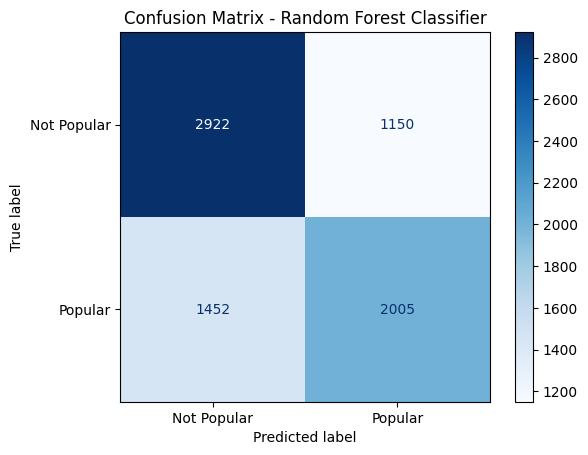


=== XGBoost Classifier ===
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      4072
           1       0.63      0.59      0.61      3457

    accuracy                           0.65      7529
   macro avg       0.65      0.65      0.65      7529
weighted avg       0.65      0.65      0.65      7529



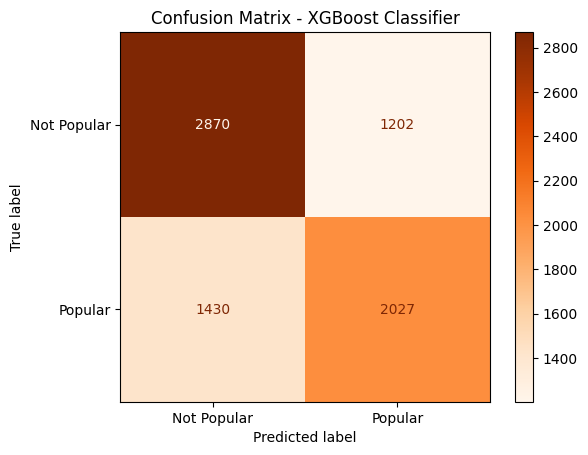

In [14]:
# =========================
# 🏷 Classification Models
# =========================

# --- Random Forest Classifier ---
print("\n=== Random Forest Classifier ===")
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_scaled, y_train_clf)
y_pred_rf_clf = clf_rf.predict(X_test_scaled)
print(classification_report(y_test_clf, y_pred_rf_clf))

# Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test_clf, y_pred_rf_clf), display_labels=["Not Popular", "Popular"]).plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# --- XGBoost Classifier ---
print("\n=== XGBoost Classifier ===")
clf_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train_scaled, y_train_clf)
y_pred_xgb = clf_xgb.predict(X_test_scaled)
print(classification_report(y_test_clf, y_pred_xgb))

ConfusionMatrixDisplay(confusion_matrix(y_test_clf, y_pred_xgb), display_labels=["Not Popular", "Popular"]).plot(cmap='Oranges')
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()


Linear Regression Mean RMSE: 2889.82

Random Forest Mean RMSE: 1788.58

XGBoost Mean RMSE: 1817.36


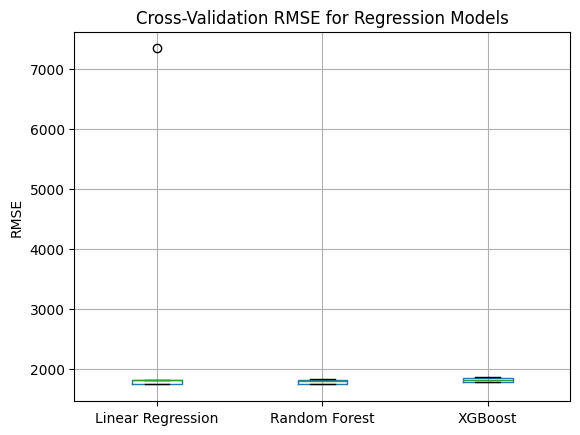

In [15]:
# =========================
# Cross-Validation (Regression)
# =========================

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}.items():
    neg_mse_scores = cross_val_score(model, scaler.fit_transform(X), y_reg, scoring='neg_mean_squared_error', cv=kf)
    rmse_scores = np.sqrt(-neg_mse_scores)
    cv_results[name] = rmse_scores
    print(f"\n{name} Mean RMSE: {rmse_scores.mean():.2f}")

pd.DataFrame(cv_results).boxplot()
plt.title("Cross-Validation RMSE for Regression Models")
plt.ylabel("RMSE")
plt.show()


In [16]:
# =========================
# Hyperparameter Tuning (XGBoost Classifier)
# =========================

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
xgb_grid.fit(X_train_scaled, y_train_clf)

tuned_acc = accuracy_score(y_test_clf, xgb_grid.best_estimator_.predict(X_test_scaled))
print(f"\nTuned XGBoost Accuracy: {tuned_acc:.4f}")


Tuned XGBoost Accuracy: 0.6648


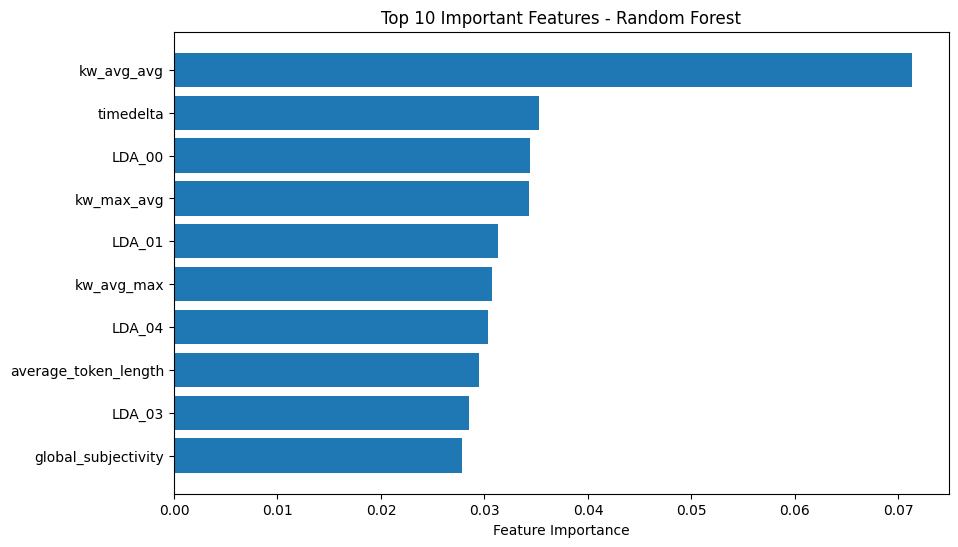

In [17]:
# =========================
# Feature Importance (RF vs XGB)
# =========================

# --- Random Forest Feature Importance ---
importances_rf = rf.feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_rf)), importances_rf[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [X.columns[i] for i in indices_rf])
plt.title('Top 10 Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.show()

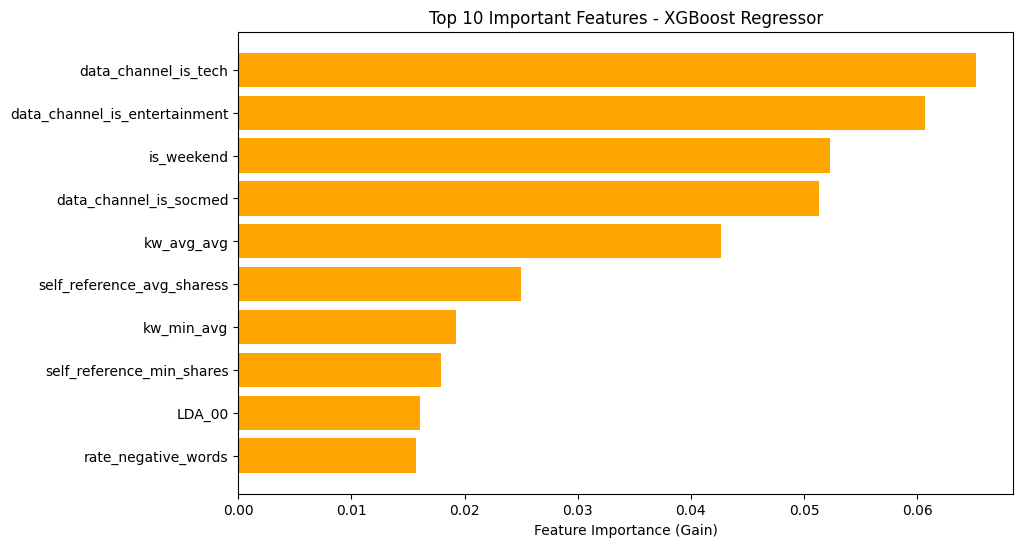

In [18]:
# --- XGBoost Feature Importance ---
importances_xgb = xgb_reg.feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color='orange')
plt.yticks(range(len(indices_xgb)), [X.columns[i] for i in indices_xgb])
plt.title('Top 10 Important Features - XGBoost Regressor')
plt.xlabel('Feature Importance (Gain)')
plt.show()